In [300]:
#Loading libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from numpy import mean
from sklearn.svm import LinearSVC

In [301]:
#Load the dataset

import pandas as pd
diabetic= pd.read_csv('C:/Users/nidhi/Desktop/diabetic_data.csv')

diabetic.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [302]:
print("Number of entries: ",len(diabetic))

Number of entries:  101766


In [303]:
#let's get a quick overview of dataset

diabetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In [304]:
diabetic.shape

(101766, 50)

In [305]:
#Checking for missing values in dataset
#In the dataset missing values are represented as '?' sign
for col in diabetic.columns:
    if diabetic[col].dtype == object:
         print(col,diabetic[col][diabetic[col] == '?'].count())
        
print('gender', diabetic['gender'][diabetic['gender'] == 'Unknown/Invalid'].count()) # gender was coded differently so we use a custom count for this one

race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0
gender 3


In [306]:
#dropping the columns with large number of missing values
diabetic = diabetic.drop(['weight','payer_code','medical_specialty'], axis = 1)

In [307]:
drop_Idx = set(diabetic[(diabetic['diag_1'] == '?') & (diabetic['diag_2'] == '?') & (diabetic['diag_3'] == '?')].index)

drop_Idx = drop_Idx.union(set(diabetic['diag_1'][diabetic['diag_1'] == '?'].index))
drop_Idx = drop_Idx.union(set(diabetic['diag_2'][diabetic['diag_2'] == '?'].index))
drop_Idx = drop_Idx.union(set(diabetic['diag_3'][diabetic['diag_3'] == '?'].index))
drop_Idx = drop_Idx.union(set(diabetic['race'][diabetic['race'] == '?'].index))
#drop_Idx = drop_Idx.union(set(diabetic[diabetic['discharge_disposition_id'] == 11].index))
drop_Idx = drop_Idx.union(set(diabetic['gender'][diabetic['gender'] == 'Unknown/Invalid'].index))
new_Idx = list(set(diabetic.index) - set(drop_Idx))
diabetic = diabetic.iloc[new_Idx]

In [308]:
#features (drugs named citoglipton and examide), all records have the same value.
#So essentially these cannot provide any interpretive or discriminatory information for predicting readmission so we decided to drop these two features also.
diabetic = diabetic.drop(['citoglipton', 'examide'], axis = 1)

In [309]:

#Checking for missing values in the data
for col in diabetic.columns:
    if diabetic[col].dtype == object:
         print(col,diabetic[col][diabetic[col] == '?'].count())
            
print('gender', diabetic['gender'][diabetic['gender'] == 'Unknown/Invalid'].count())


race 0
gender 0
age 0
diag_1 0
diag_2 0
diag_3 0
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0
gender 0


In [310]:
#Let's take a look at the unique values for each column.
# for each column
for c in list(diabetic.columns):
    
    # get a list of unique values
    n = diabetic[c].unique()
    
    # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
    if len(n)<30:
        print(c)
        print(n)
    else:
        print(c + ': ' +str(len(n)) + ' unique values')

encounter_id: 98052 unique values
patient_nbr: 68629 unique values
race
['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']
gender
['Female' 'Male']
age
['[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)' '[70-80)'
 '[80-90)' '[90-100)' '[0-10)']
admission_type_id
[1 2 3 6 4 5 8 7]
discharge_disposition_id
[ 1  3  6  2  5 11  7 25 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
admission_source_id
[ 7  2  4  1  5  6 20  3 17  8  9 14 10 22 11 25 13]
time_in_hospital
[ 3  2  1  4  5 13 12  9  7 10 11  6  8 14]
num_lab_procedures: 118 unique values
num_procedures
[0 5 1 6 2 3 4]
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency: 33 unique values
number_inpatient
[ 0  1  2  3  6  5  4  7  8  9 15 10 11 14 12 13 16 21 18 19]
diag_1: 713 unique values
diag_2: 740 unique values
diag_3: 786 unique values
number_diagnoses
[ 9  6  7  5  8  3  4 16 12 13 15 10 11 14]
max_glu_serum
['None' '>300' 'Norm' '>200']
A1Cresult
['None' '>7' '>

In [311]:
#The first set of categorical data we will deal with are these columns
cols_cat = ['race', 'gender']

In [312]:
cols_cat_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
diabetic[cols_cat_num] = diabetic[cols_cat_num].astype('str')

In [313]:
# Now we are ready to make all of our categorical features
diabetic_cat = pd.get_dummies(diabetic[cols_cat + cols_cat_num ],drop_first = True)

In [314]:
diabetic_cat = pd.get_dummies(diabetic[cols_cat + cols_cat_num ],drop_first = True)

In [315]:
diabetic_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,...,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [316]:
diabetic = pd.concat([diabetic,diabetic_cat], axis = 1)

In [317]:
cols_all_cat = list(diabetic_cat.columns)

In [318]:
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
# keys is the same as before
for col in keys:
    diabetic[col] = diabetic[col].replace('No', 0)
    diabetic[col] = diabetic[col].replace('Steady', 1)
    diabetic[col] = diabetic[col].replace('Up', 2)
    diabetic[col] = diabetic[col].replace('Down', 3)

In [319]:
diabetic['change'] = diabetic['change'].replace('Ch', 1)
diabetic['change'] = diabetic['change'].replace('No', 0)
diabetic['diabetesMed'] = diabetic['diabetesMed'].replace('Yes', 1)
diabetic['diabetesMed'] = diabetic['diabetesMed'].replace('No', 0)

In [320]:
#We also reduced both A1C test result and Glucose serum test 
#result into categories of Normal,Abnormal and Not tested.
diabetic['A1Cresult'] = diabetic['A1Cresult'].replace('>7', 1)
diabetic['A1Cresult'] = diabetic['A1Cresult'].replace('>8', 1)
diabetic['A1Cresult'] = diabetic['A1Cresult'].replace('Norm', 0)
diabetic['A1Cresult'] = diabetic['A1Cresult'].replace('None', 2)
diabetic['max_glu_serum'] = diabetic['max_glu_serum'].replace('>200', 1)
diabetic['max_glu_serum'] = diabetic['max_glu_serum'].replace('>300', 1)
diabetic['max_glu_serum'] = diabetic['max_glu_serum'].replace('Norm', 0)
diabetic['max_glu_serum'] = diabetic['max_glu_serum'].replace('None', 2)

In [321]:
# code age intervals [0-10) - [90-100) from 1-10
for i in range(0,10):
    diabetic['age'] = diabetic['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)
diabetic['age'].value_counts()

8     25305
7     21809
9     16702
6     16697
5      9265
4      3548
10     2717
3      1478
2       466
1        65
Name: age, dtype: int64

In [322]:
diabetic['diag_1'] = diabetic['diag_1'].str.replace('V', '')
diabetic['diag_2'] = diabetic['diag_2'].str.replace('V', '')
diabetic['diag_3'] = diabetic['diag_3'].str.replace('V', '')
diabetic['diag_1'] = diabetic['diag_1'].str.replace('E', '')
diabetic['diag_2'] = diabetic['diag_2'].str.replace('E', '')
diabetic['diag_3'] = diabetic['diag_3'].str.replace('E', '')
diabetic['diag_1'] = diabetic['diag_1'].astype(float)
diabetic['diag_2'] = diabetic['diag_2'].astype(float)
diabetic['diag_3'] = diabetic['diag_3'].astype(float)

In [323]:
diabetic = diabetic.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
diabetic.shape

(68629, 98)

In [324]:
diabetic['readmitted'].value_counts()

NO     40879
>30    21624
<30     6126
Name: readmitted, dtype: int64

In [325]:
diabetic['OUTPUT_LABEL'] = (diabetic.readmitted == '<30').astype('int')

In [326]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

print('Prevalence:%.3f'%calc_prevalence(diabetic['OUTPUT_LABEL'].values))


Prevalence:0.089


Text(0.5, 1.0, 'Distrinution of Readmission')

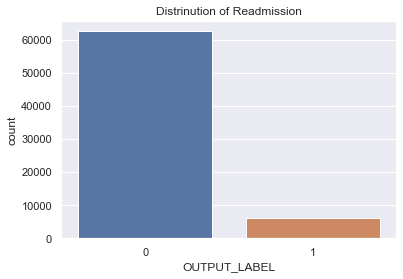

In [327]:
#DATA VISUALIZATION
# Distribution of Readmission 
sns.countplot(diabetic['OUTPUT_LABEL']).set_title('Distrinution of Readmission')

Text(0.5, 1.0, 'Time in Hospital VS. Readmission')

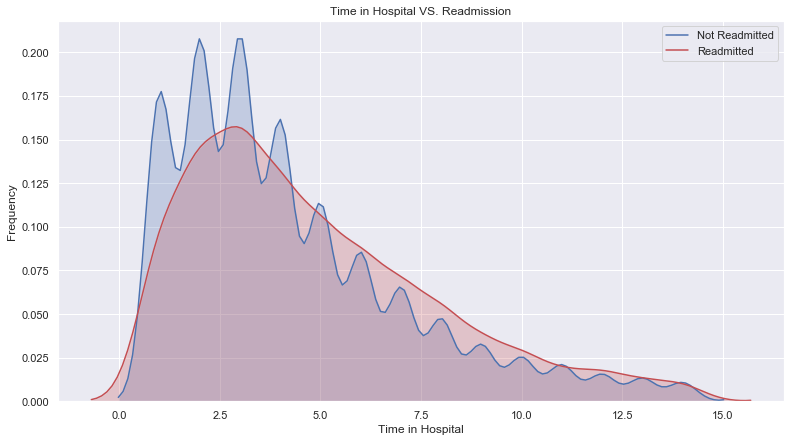

In [328]:
fig = plt.figure(figsize=(13,7),)
ax=sns.kdeplot(diabetic.loc[(diabetic['OUTPUT_LABEL'] == 0),'time_in_hospital'] , color='b',shade=True,label='Not Readmitted')
ax=sns.kdeplot(diabetic.loc[(diabetic['OUTPUT_LABEL'] == 1),'time_in_hospital'] , color='r',shade=True, label='Readmitted')
ax.set(xlabel='Time in Hospital', ylabel='Frequency')
plt.title('Time in Hospital VS. Readmission')

Text(0.5, 1.0, 'Age of Patient VS. Readmission')

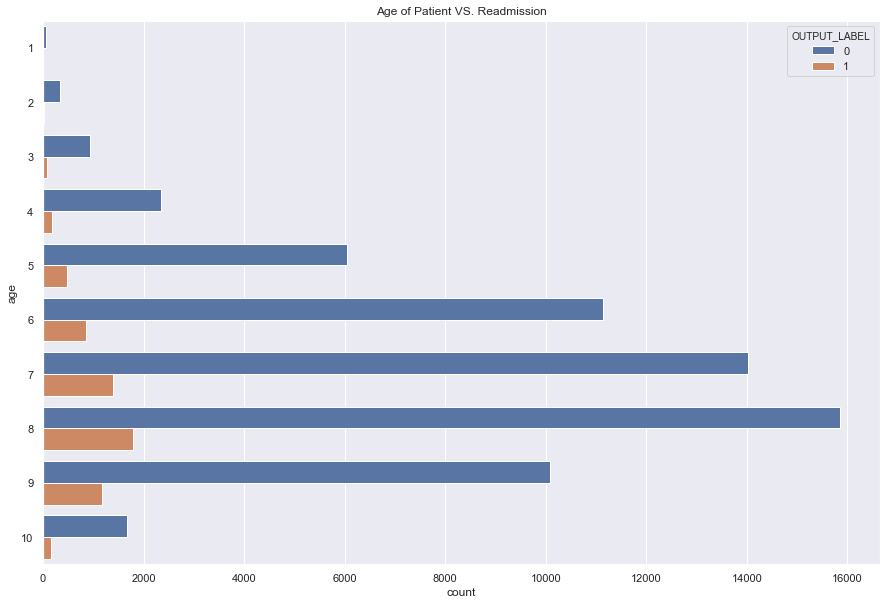

In [329]:
fig = plt.figure(figsize=(15,10))
sns.countplot(y= diabetic['age'], hue = diabetic['OUTPUT_LABEL']).set_title('Age of Patient VS. Readmission')

In [330]:
corr_matrix = diabetic.corr()
corr_matrix["OUTPUT_LABEL"].sort_values(ascending=False)

OUTPUT_LABEL                   1.000000
number_inpatient               0.099698
discharge_disposition_id_22    0.088348
discharge_disposition_id_3     0.057535
time_in_hospital               0.052030
                                 ...   
diag_1                        -0.015372
discharge_disposition_id_11   -0.039080
encounter_id                  -0.048829
glimepiride-pioglitazone            NaN
metformin-rosiglitazone             NaN
Name: OUTPUT_LABEL, Length: 93, dtype: float64

In [331]:
#Models 
#We are using following function to evaluate the performance of the model

In [332]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def print_report(y_actual, y_pred, thresh):
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [333]:
#Since we balanced our training data, let's set our threshold at 0.5 to label a predicted sample as positive.
thresh = 0.5

In [334]:
feature = ['age', 'race_Asian',	'race_Caucasian',	'race_Hispanic','race_Other',	'gender_Male','admission_type_id_2','admission_type_id_3','admission_type_id_4','admission_type_id_5','admission_type_id_6','admission_type_id_7','admission_type_id_8','discharge_disposition_id_10','discharge_disposition_id_11','discharge_disposition_id_12','discharge_disposition_id_13','discharge_disposition_id_14','discharge_disposition_id_15','discharge_disposition_id_16','discharge_disposition_id_17','discharge_disposition_id_18','discharge_disposition_id_19','discharge_disposition_id_2','discharge_disposition_id_20','discharge_disposition_id_22','discharge_disposition_id_23','discharge_disposition_id_24','discharge_disposition_id_25','discharge_disposition_id_27','discharge_disposition_id_28','discharge_disposition_id_3','discharge_disposition_id_4','discharge_disposition_id_5','discharge_disposition_id_6','discharge_disposition_id_7','discharge_disposition_id_8','discharge_disposition_id_9','admission_source_id_10','admission_source_id_11','admission_source_id_13','admission_source_id_14','admission_source_id_17','admission_source_id_2','admission_source_id_20','admission_source_id_22','admission_source_id_25','admission_source_id_3','admission_source_id_4','admission_source_id_5',	'admission_source_id_6',	'admission_source_id_7',	'admission_source_id_8','admission_source_id_9','time_in_hospital', 'num_lab_procedures','num_procedures', 'num_medications', 'number_outpatient', 
                 'number_emergency', 'number_inpatient', 'number_diagnoses', 
                 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide',
                  'max_glu_serum', 'A1Cresult', 'diag_1','diag_2','diag_3']

In [335]:
X = diabetic[feature]
y = diabetic['OUTPUT_LABEL']
all = pd.concat([X, y], axis=1) 
# shuffle the samples
all = all.sample(n = len(all), random_state = 42)
all = all.reset_index(drop = True)
# Save 30% of the data as validation and test data 
df_valid_test=all.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(all)))
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)
#use the rest of the data as training data
df_train_all=all.drop(df_valid_test.index)

Split size: 0.300


In [336]:
#split the training data into positive and negative
rows_pos = all.OUTPUT_LABEL == 1
X_train_pos = all.loc[rows_pos]
X_train_neg =all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([X_train_pos, X_train_neg.sample(n = len(X_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
X_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(X_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence(n = 12252):0.500


In [337]:
X_train = df_train[feature].values
X_train_all = df_train_all[feature].values
X_valid = df_valid[feature].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (48040, 88)
Training shapes: (12252, 88) (12252,)
Validation shapes: (10295, 88) (10295,)


In [338]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(X_train_all)
X_train_sc= scaler.fit_transform(X_train)
X_valid_sc= scaler.fit_transform(X_valid)

In [339]:
#K-nearest neighbors

In [340]:
#k-nearest neighbours
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train_sc, y_train)

KNeighborsClassifier(n_neighbors=100)

In [341]:
y_train_preds = knn.predict_proba(X_train_sc)[:,1]
y_valid_preds = knn.predict_proba(X_valid_sc)[:,1]

print('knn')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, knn_train_precision, knn_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, knn_valid_precision, knn_valid_specificity= print_report(y_valid,y_valid_preds, thresh)

knn
Training:
AUC:0.651
accuracy:0.604
recall:0.455
precision:0.648
specificity:0.713
 
Validation:
AUC:0.654
accuracy:0.697
recall:0.525
precision:0.146
specificity:0.671
 


In [342]:
#Gradient Boosting Classifier

In [343]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_sc, y_train)

GradientBoostingClassifier(learning_rate=1.0, random_state=42)

In [344]:
y_train_preds = gbc.predict_proba(X_train_sc)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_sc)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity= print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:0.809
accuracy:0.726
recall:0.708
precision:0.734
specificity:0.743
 
Validation:
AUC:0.673
accuracy:0.587
recall:0.646
precision:0.127
specificity:0.582
 


In [345]:
#Naive Bayes

In [346]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb= GaussianNB()
nb.fit(X_train_sc, y_train)

GaussianNB()

In [347]:
y_train_preds = nb.predict_proba(X_train_sc)[:,1]
y_valid_preds = nb.predict_proba(X_valid_sc)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity= print_report(y_valid,y_valid_preds, thresh)

Naive Bayes
Training:
AUC:0.519
accuracy:0.514
recall:0.992
precision:0.507
specificity:0.036
 
Validation:
AUC:0.500
accuracy:0.914
recall:0.000
precision:0.000
specificity:1.000
 


In [348]:
#Random Forest

In [349]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.ensemble import RandomForestClassifier
#rf = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
model=rf.fit(X_train_sc, y_train)

In [350]:
y_train_preds = rf.predict_proba(X_train_sc)[:,1]
y_valid_preds = rf.predict_proba(X_valid_sc)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.684
accuracy:0.626
recall:0.558
precision:0.646
specificity:0.694
 
Validation:
AUC:0.663
accuracy:0.655
recall:0.549
precision:0.133
specificity:0.665
 


In [351]:
#Feature Importance: random forest

In [352]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = feature,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head()

,importance
number_inpatient,0.158744
discharge_disposition_id_22,0.109983
discharge_disposition_id_3,0.089603
time_in_hospital,0.078903
discharge_disposition_id_11,0.071552


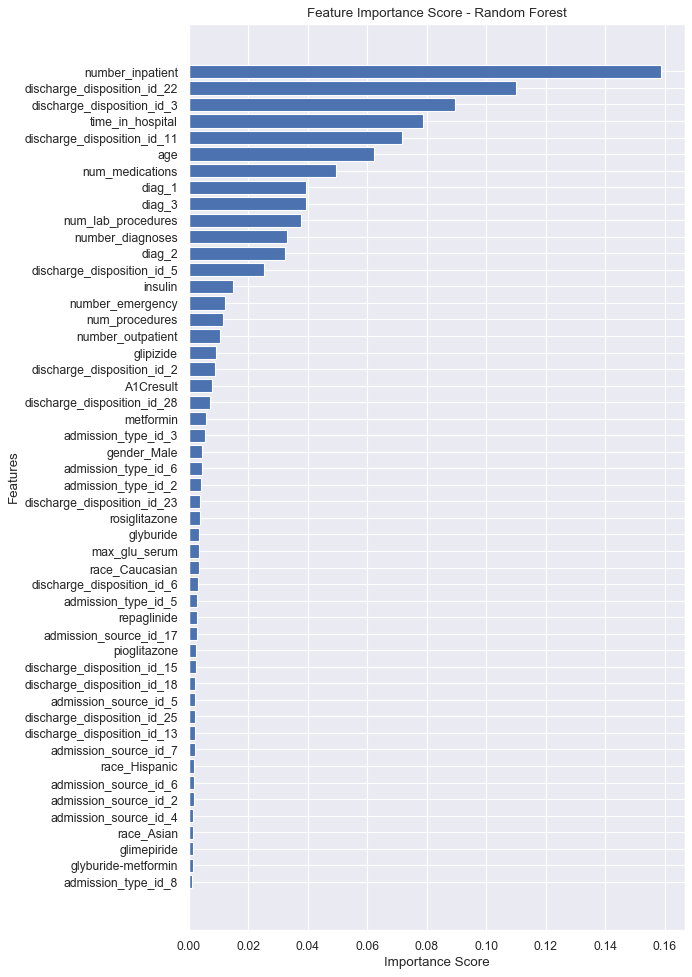

In [353]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()


In [354]:
#Model Comparision
df_results = pd.DataFrame({'classifier':['knn','knn','rf','rf','gbc','gbc','nb','nb'],
                    'data_set':['train','valid']*4,
                            'auc':[knn_train_auc,knn_valid_auc,rf_train_auc,rf_valid_auc,gbc_train_auc,gbc_valid_auc,nb_train_auc,nb_valid_auc],
                            'accuracy':[knn_train_accuracy,knn_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_train_accuracy,gbc_valid_accuracy,nb_train_accuracy,nb_valid_accuracy],
                            'recall':[knn_train_recall,knn_valid_recall,rf_train_recall,rf_valid_recall,gbc_train_recall,gbc_valid_recall,nb_train_recall,nb_valid_recall],
                            'precision':[knn_train_precision,knn_valid_precision,rf_train_precision,rf_valid_precision,gbc_train_precision,gbc_valid_precision,nb_train_precision,nb_valid_precision],
                            'specificity':[knn_train_specificity,knn_valid_specificity,rf_train_specificity,rf_valid_specificity,gbc_train_specificity,gbc_valid_specificity,nb_train_specificity,nb_valid_specificity],
                          })


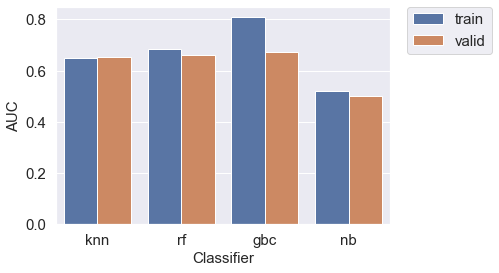

In [355]:

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data= df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

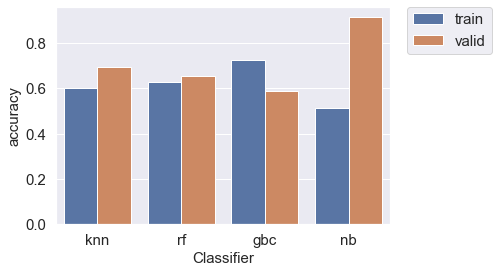

In [356]:

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
ax = sns.barplot(x="classifier", y="accuracy", hue="data_set", data= df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('accuracy', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

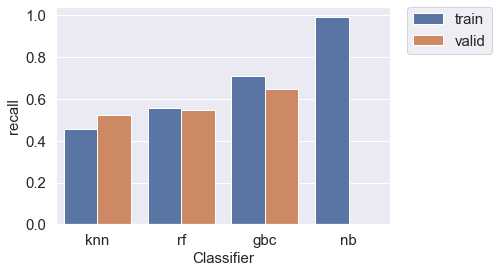

In [357]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
ax = sns.barplot(x="classifier", y="recall", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('recall', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

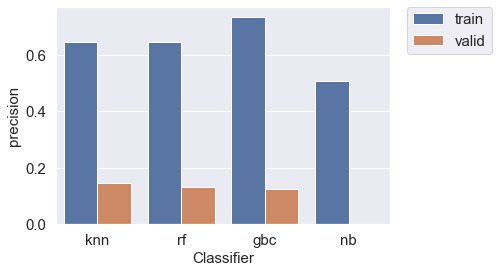

In [358]:

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
ax = sns.barplot(x="classifier", y="precision", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('precision', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

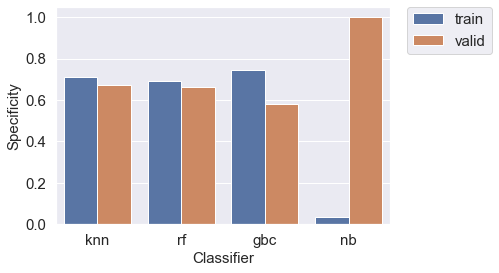

In [359]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
ax = sns.barplot(x="classifier", y="specificity", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('Specificity', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

In [360]:
#LEARNING CURVE
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

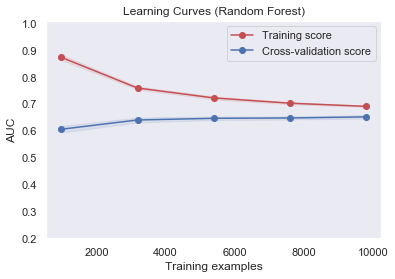

In [361]:

title = "Learning Curves (Random Forest)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = RandomForestClassifier(max_depth = 6, random_state = 42)
plot_learning_curve(estimator, title, X_train_sc, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

In [362]:
#Model Selection: Hyperparameter tuning
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [363]:
#Let's create a grid over a few of these
from sklearn.model_selection import RandomizedSearchCV

# number of trees
n_estimators = range(200,1000,200)
# maximum number of features to use at each split
max_features = ['auto','sqrt']
# maximum depth of the tree
max_depth = range(1,10,1)
# minimum number of samples to split a node
min_samples_split = range(2,10,2)
# criterion for evaluating a split
criterion = ['gini','entropy']

# random grid

random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'criterion':criterion}

print(random_grid)


{'n_estimators': range(200, 1000, 200), 'max_features': ['auto', 'sqrt'], 'max_depth': range(1, 10), 'min_samples_split': range(2, 10, 2), 'criterion': ['gini', 'entropy']}


In [364]:

from sklearn.metrics import make_scorer, roc_auc_score
auc_scoring = make_scorer(roc_auc_score)

In [365]:

# create the randomized search cross-validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 2, scoring=auc_scoring,
                               verbose = 1, random_state = 42)

In [366]:
# fit the random search model (this will take a few minutes)
import time
t1 = time.time()
rf_random.fit(X_train_sc, y_train)
t2 = time.time()
print(t2-t1)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.9min finished


122.89825415611267


In [367]:
#see the best parameters

rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 4,
 'max_features': 'sqrt',
 'max_depth': 8,
 'criterion': 'entropy'}

In [368]:

y_train_preds = rf.predict_proba(X_train_sc)[:,1]
y_valid_preds = rf.predict_proba(X_valid_sc)[:,1]

print('Baseline Random Forest')
rf_train_auc_base = roc_auc_score(y_train, y_train_preds)
rf_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(rf_train_auc_base))
print('Validation AUC:%.3f'%(rf_valid_auc_base))

print('Optimized Random Forest')
y_train_preds_random = rf_random.best_estimator_.predict_proba(X_train_sc)[:,1]
y_valid_preds_random = rf_random.best_estimator_.predict_proba(X_valid_sc)[:,1]

rf_train_auc = roc_auc_score(y_train, y_train_preds_random)
rf_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(rf_train_auc))
print('Validation AUC:%.3f'%(rf_valid_auc))

Baseline Random Forest
Training AUC:0.684
Validation AUC:0.663
Optimized Random Forest
Training AUC:0.716
Validation AUC:0.681


In [369]:
#Optimize gradient boosting classifier
# number of trees
n_estimators = range(100,500,100)
# maximum depth of the tree
max_depth = range(1,5,1)
# learning rate
learning_rate = [0.001,0.01,0.1]
# random grid
random_grid_gbc = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate}
# create the randomized search cross-validation
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid_gbc,
                                n_iter = 20, cv = 2, scoring=auc_scoring,
                                verbose = 0, random_state = 42)
t1 = time.time()
gbc_random.fit(X_train_sc, y_train)
t2 = time.time()
print(t2-t1)

285.57605266571045


In [370]:
gbc_random.best_params_

{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

In [371]:
y_train_preds = gbc.predict_proba(X_train_sc)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_sc)[:,1]

print('Baseline gbc')
gbc_train_auc_base = roc_auc_score(y_train, y_train_preds)
gbc_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(gbc_train_auc_base))
print('Validation AUC:%.3f'%(gbc_valid_auc_base))

print('Optimized gbc')
y_train_preds_random = gbc_random.best_estimator_.predict_proba(X_train_sc)[:,1]
y_valid_preds_random = gbc_random.best_estimator_.predict_proba(X_valid_sc)[:,1]
gbc_train_auc = roc_auc_score(y_train, y_train_preds_random)
gbc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(gbc_train_auc))
print('Validation AUC:%.3f'%(gbc_valid_auc))

Baseline gbc
Training AUC:0.809
Validation AUC:0.673
Optimized gbc
Training AUC:0.692
Validation AUC:0.677


In [372]:
#Hyperparameter Tunning Results
df_results = pd.DataFrame({'classifier':['gbc','gbc','rf','rf'],
                           'data_set':['base','optimized']*2,
                          'auc':[gbc_valid_auc_base,gbc_valid_auc,
                                 rf_valid_auc_base,rf_valid_auc,
                                ],
                          })

In [373]:

df_results

,classifier,data_set,auc
0,gbc,base,0.672682
1,gbc,optimized,0.676998
2,rf,base,0.662602
3,rf,optimized,0.680851


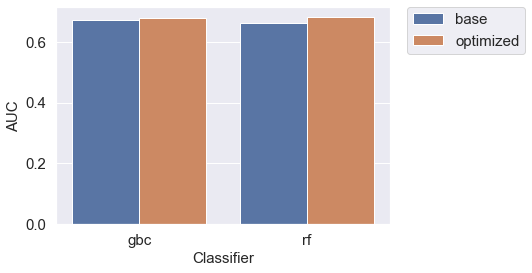

In [374]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

In [375]:
#Model Evaluation
#Now that we have selected our best model. Let's evaluate the performance of the test set.
X_test = df_test[feature].values
y_test = df_test['OUTPUT_LABEL'].values
X_test_sc = scaler.fit_transform(X_test)

In [376]:

best_model= gbc_random.best_estimator_

In [377]:

y_train_preds = best_model.predict_proba(X_train_sc)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_sc)[:,1]
y_test_preds = best_model.predict_proba(X_test_sc)[:,1]

In [378]:
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity  = print_report(y_valid,y_valid_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity  = print_report(y_test,y_test_preds, thresh)

Training:
AUC:0.692
accuracy:0.631
recall:0.558
precision:0.653
specificity:0.703
 
Validation:
AUC:0.677
accuracy:0.669
recall:0.557
precision:0.140
specificity:0.680
 
Test:
AUC:0.673
accuracy:0.674
recall:0.548
precision:0.150
specificity:0.687
 


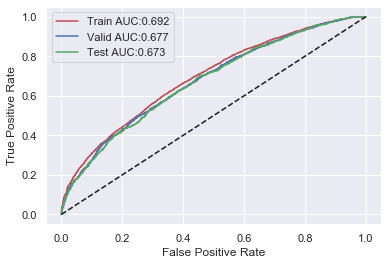

In [379]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()